# Report
## Blood Pressure Monitoring
Measurements between 15.07.2017 - #FIXME

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
import seaborn as sns

%matplotlib inline

In [52]:
# Load data
filepath = "data/data.csv"
raw_data = pd.read_csv(filepath, parse_dates=[["Date", "Time"]])

# FIXME maybe cleaning (datetime)
data = raw_data.set_index(pd.DatetimeIndex(raw_data.Date_Time)).drop("Date_Time", axis=1)
#data.head()

### Blood Pressure Values

#### Visualization

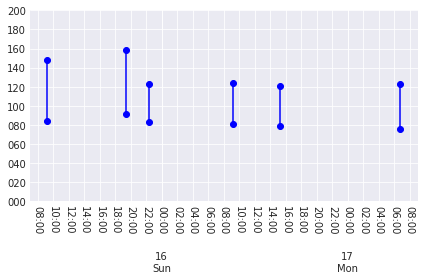

In [62]:
#FIXME Plots per week


# Blood pressure plot
sns.set_style("darkgrid")
fig, ax = plt.subplots()

for ix, row in data.iterrows():
    # Sys point marker
    ax.plot(ix, row.Sys,
            marker="o", color="b")
    # Dia point marker
    ax.plot(ix, row.Dia,
            marker="o", color="b")
    # Vertical line between points
    ax.axvline(x=ix, ymin=row.Dia/200, ymax=row.Sys/200, 
               color="b")

# X Axis enhancements
ax.xaxis.set_minor_locator(mdates.DayLocator())
ax.xaxis.set_minor_formatter(mdates.DateFormatter("\n\n\n\n%d\n%a"))
ax.xaxis.grid(True, which="minor")
ax.xaxis.set_major_locator(mdates.HourLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
plt.xticks(rotation=270)

# Y Axis enhancements
plt.yticks(range(0, 201, 20))
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter("%0.3d"))

plt.tight_layout()
plt.show()

### Pulse Values

#### Visualization

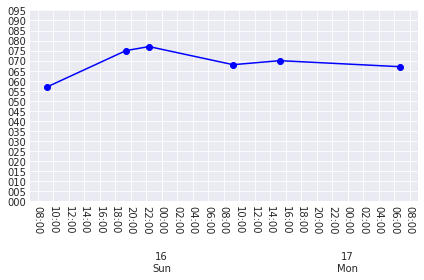

In [61]:
# Pulse plot
sns.set_style("darkgrid")
fig, ax = plt.subplots()

# Line plot with data points marked
plt.plot_date(data.index, data.Pulse, linestyle="-", color="b")

# X Axis enhancements
ax.xaxis.set_minor_locator(mdates.DayLocator())
ax.xaxis.set_minor_formatter(mdates.DateFormatter("\n\n\n\n%d\n%a"))
ax.xaxis.grid(True, which="minor")
ax.xaxis.set_major_locator(mdates.HourLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
plt.xticks(rotation=270)

# Y Axis enhancements
#ax.yaxis.set_major_formatter(mtick.FormatStrFormatter("%0.2d"))
plt.yticks(range(0, (data.Pulse.max() + 20), 5))
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter("%0.3d"))

plt.tight_layout()
plt.show()

In [50]:
# Metrices Utils

def make_metrices_dict(data):
    """ Creates dict of standard metrices and corresponding values
    :Param data - df with 
    :Return metrices dict
    """
    metrices_dict = {}

    #mean
    metrices_dict["Systolic mean"] = data.Sys.mean()
    metrices_dict["Diastolic mean"] = data.Dia.mean()

    #sys max min
    metrices_dict["Systolic max"] = data.Sys.max()
    metrices_dict["Systolic min"] = data.Sys.min()

    #dia max min
    metrices_dict["Diastolic max"] = data.Dia.max()
    metrices_dict["Diastolic min"] = data.Dia.min()
    
    #count of high / low blood pressure measures
    metrices_dict["High Pressure Measures"] = int(data[(data.Sys > 139) | (data.Dia > 89)].count()[0])
    metrices_dict["Low Pressure Measures"] = int(data[(data.Sys < 100) | (data.Dia < 60)].count()[0])
    
    return metrices_dict


#### Metrices

Total

In [51]:
# Metrices Total

metrices_total = make_metrices_dict(data)

metrices_table_total = pd.DataFrame.from_dict(metrices_total, orient="index").rename(columns={0: "Value"})
metrices_table_total

,Value
Systolic mean,133.0
Diastolic mean,82.5
Systolic max,159.0
Systolic min,121.0
Diastolic max,92.0
Diastolic min,76.0
High Pressure Measures,2.0
Low Pressure Measures,0.0


Per Day

In [ ]:
#mean per day
#FIXME rolling | subset per day

### Data Table

In [42]:
# Data table
data_table = data
data_table.index.rename("ToM", inplace=True)

data_table

,Sys,Dia,Pulse
ToM,,,
2017-07-15 09:16:00,148,84,57
2017-07-15 19:24:00,159,92,75
2017-07-15 22:23:00,123,83,77
2017-07-16 09:14:00,124,81,68
2017-07-16 15:16:00,121,79,70
2017-07-17 06:45:00,123,76,67
